In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
with open("./metadata_preprocessing/data_descr.txt", "r") as f:
    data_descr = f.read().split("\n")
    data_descr.append("")
data_descr = pd.DataFrame(np.array(data_descr).reshape(len(data_descr)//4, 4))
data_descr.drop(columns=[2, 3], inplace=True)
data_descr.rename(columns={0: "feature", 1: "description"}, inplace=True)
data_descr.to_csv("./metadata_preprocessing/data_descriptions.csv", index=False)

In [3]:
df = pd.read_parquet("preprocessed_all.parquet")

In [4]:
def feature_per_target(feature, ylabel=None):
    plt.figure(figsize=(20, 6))
    sns.stripplot(x="ProtocolName", y=feature,data=df,
                  jitter=0.2, size=2, alpha=0.75)
    plt.xticks(rotation=90)
    plt.grid()
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show();

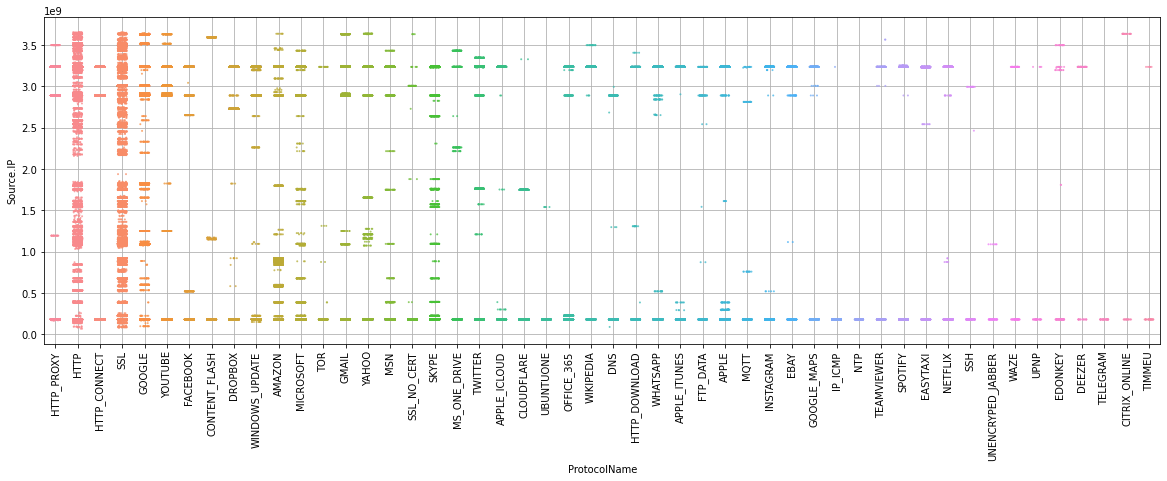

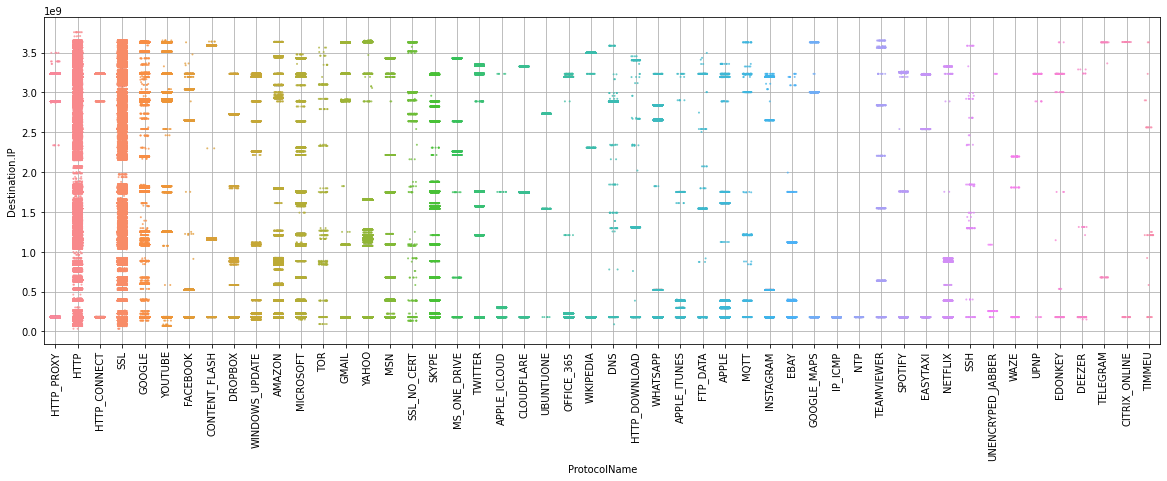

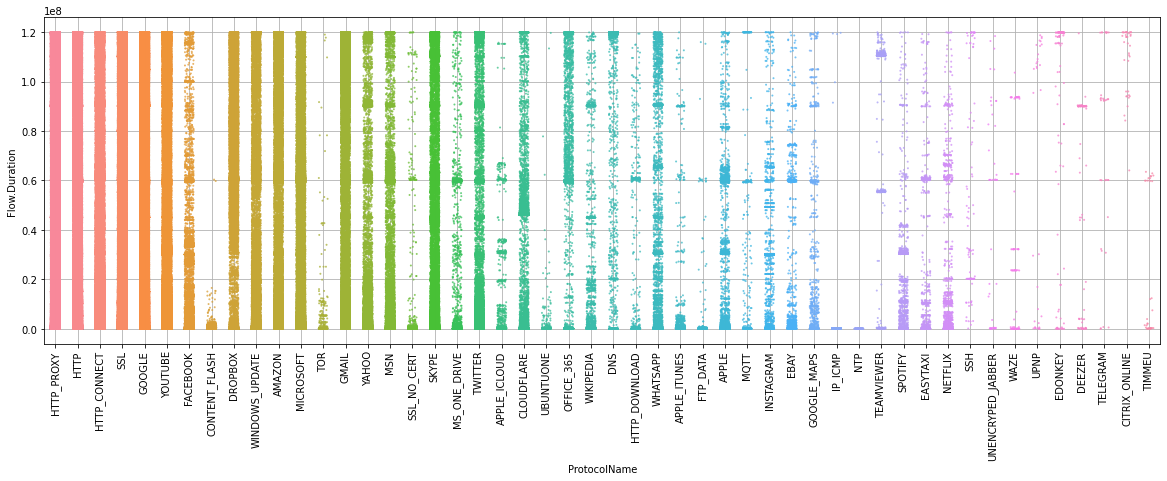

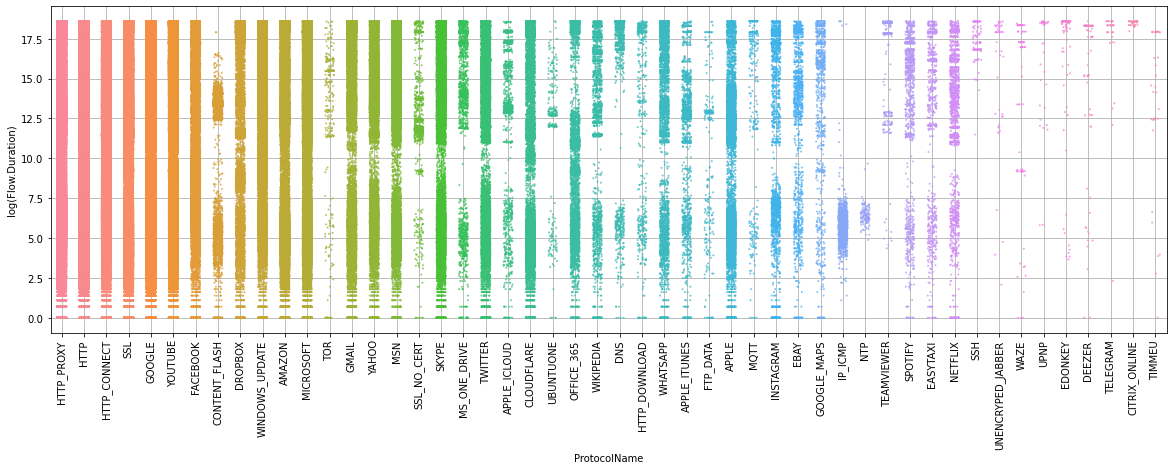

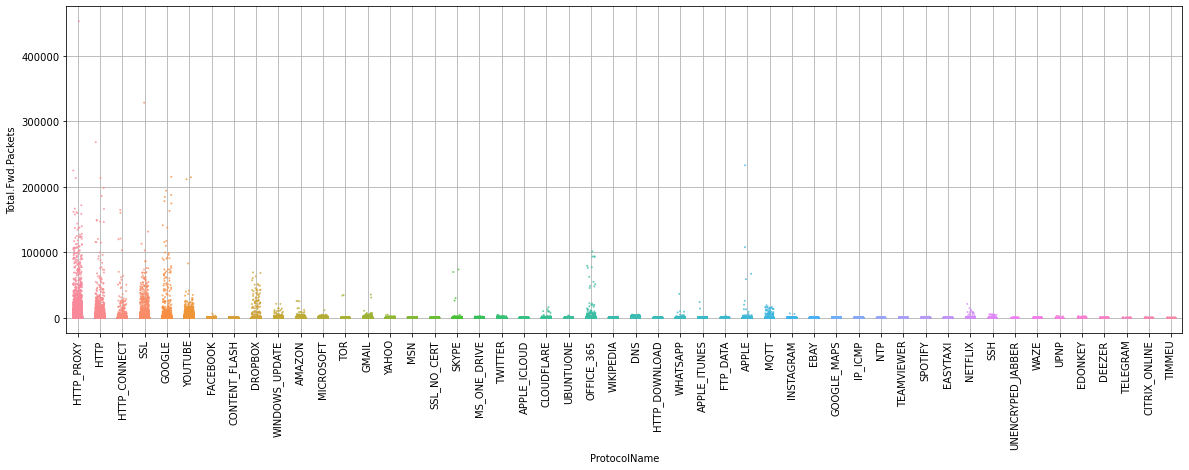

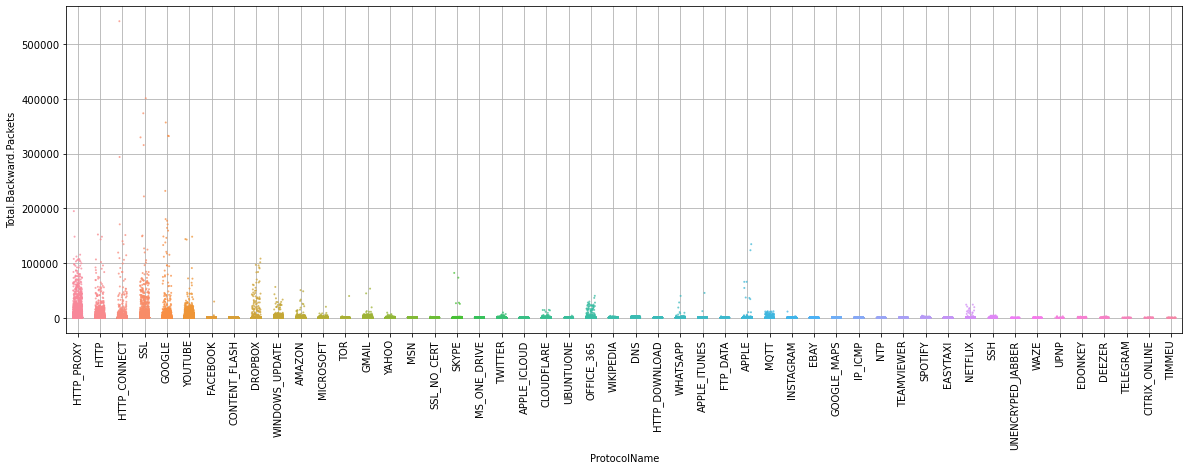

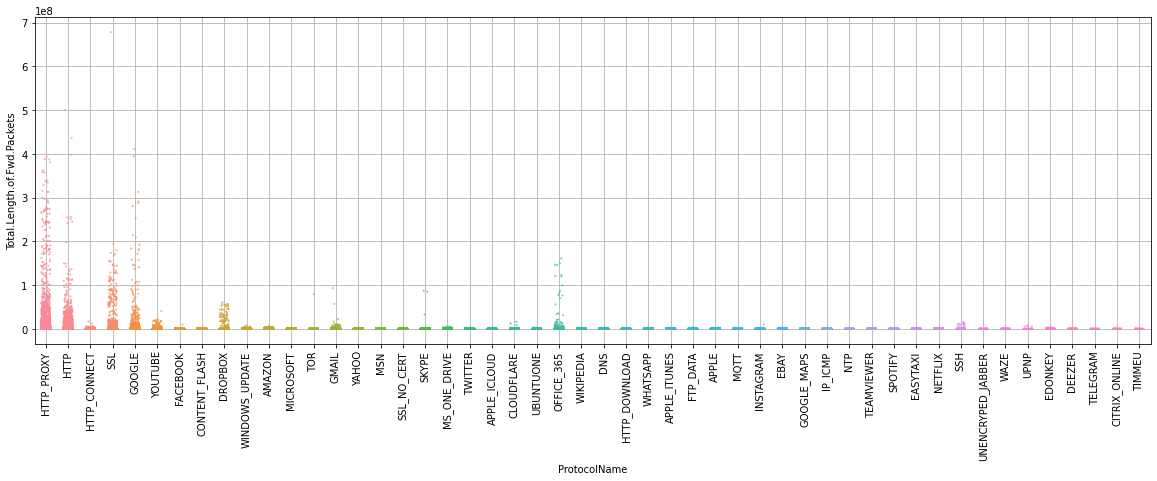

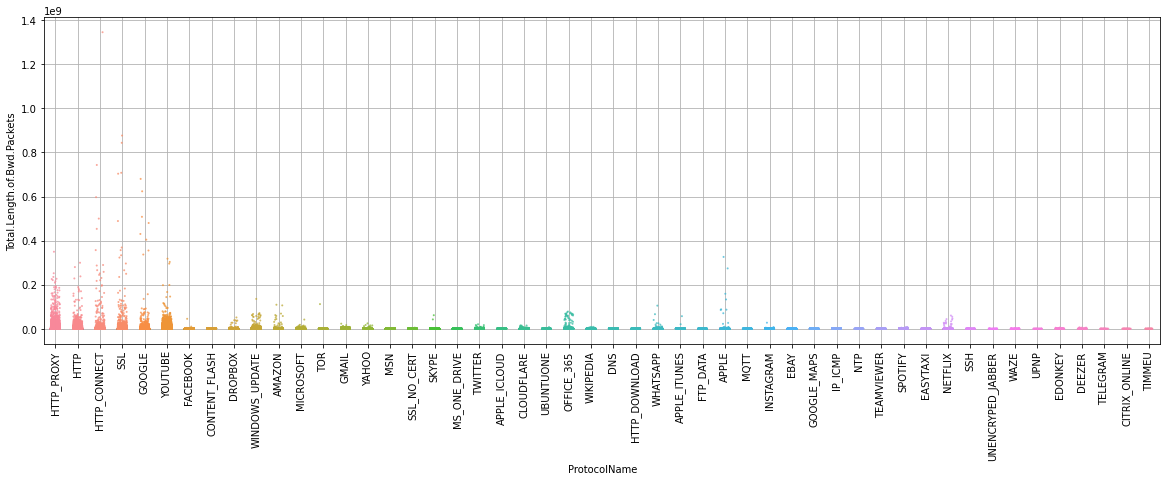

In [5]:
feature_per_target("Source.IP")
feature_per_target("Destination.IP")
feature_per_target("Flow.Duration")
feature_per_target(np.log(df["Flow.Duration"]), "log(Flow.Duration)")
feature_per_target("Total.Fwd.Packets")
feature_per_target("Total.Backward.Packets")
feature_per_target("Total.Length.of.Fwd.Packets")
feature_per_target("Total.Length.of.Bwd.Packets")

count    3.567193e+06
mean     1.211650e+01
std      5.646195e+00
min      0.000000e+00
25%      6.476972e+00
50%      1.329899e+01
75%      1.762226e+01
max      1.860300e+01
Name: Flow.Duration, dtype: float64

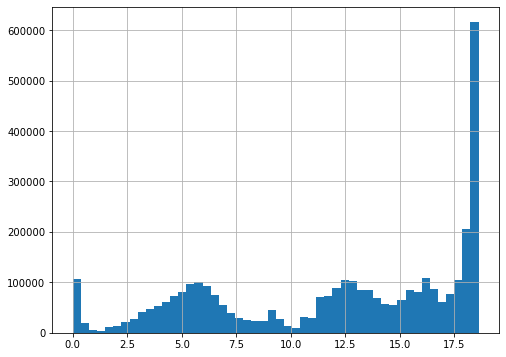

In [6]:
plt.figure(figsize=(8, 6))
feat = np.log(df["Flow.Duration"])
feat.hist(bins=50)
feat.describe()

count    3.567193e+06
mean     1.836522e+00
std      1.547308e+00
min      0.000000e+00
25%      6.931472e-01
50%      1.791759e+00
75%      2.708050e+00
max      1.302407e+01
Name: Total.Fwd.Packets, dtype: float64

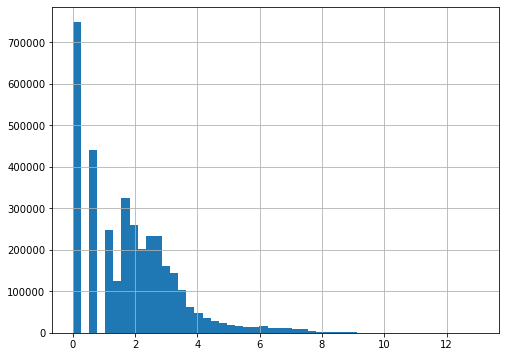

In [7]:
plt.figure(figsize=(8, 6))
feat = np.log(df["Total.Fwd.Packets"])
feat.hist(bins=50)
feat.describe()

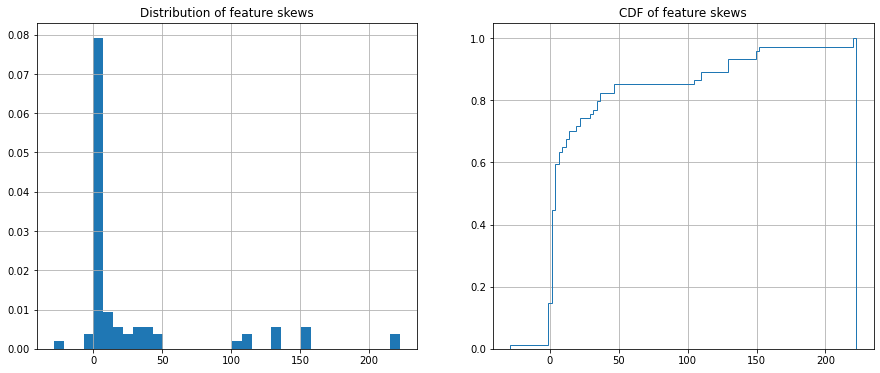

In [8]:
feature_skews = {col: skew(df[col])
                 for col in df.select_dtypes([np.number]).columns}
feature_skews = pd.Series(feature_skews).sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
feature_skews.hist(bins=35, density=True,  ax=axes[0])
feature_skews.hist(bins=100, cumulative=True, density=True, histtype="step", ax=axes[1])
axes[0].set_title("Distribution of feature skews")
axes[1].set_title("CDF of feature skews");

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


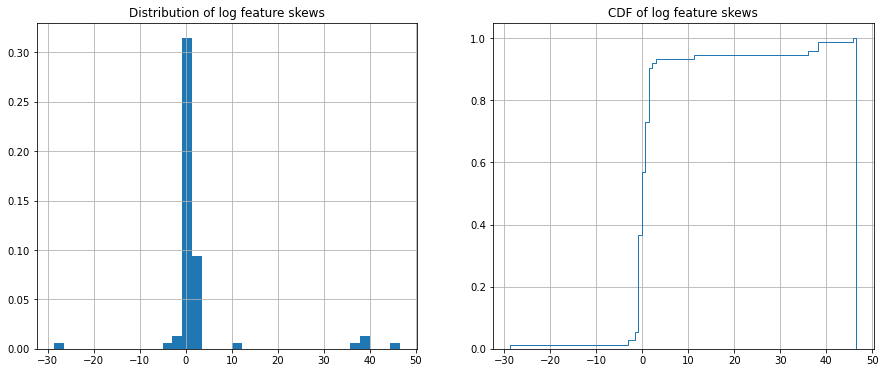

In [9]:
log_feature_skews = {col: skew(np.log(df[col].abs()+1))
                     for col in df.select_dtypes([np.number]).columns}
log_feature_skews = pd.Series(log_feature_skews)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
log_feature_skews.hist(bins=35, density=True,  ax=axes[0])
log_feature_skews.hist(bins=100, cumulative=True, density=True, histtype="step", ax=axes[1])
axes[0].set_title("Distribution of log feature skews")
axes[1].set_title("CDF of log feature skews");

In [10]:
log_feature_skews.abs().sort_values(ascending=False).head(10)

Protocol.Other           46.531250
ECE.Flag.Count           38.930725
RST.Flag.Count           38.667710
Protocol.UDP             36.437500
Protocol.TCP             28.687500
FIN.Flag.Count           11.778417
Bwd.Packet.Length.Min     3.335136
target                    3.026304
Bwd.IAT.Min               2.758465
Active.Std                2.078930
dtype: float64

Can address the significant skew highlighted by pandas_profiling by taking the log of the features. To ensure that any erroneous negatives as well as zeros are handled, the transformation required is `log(abs(x)+1)`.

In [11]:
for col in df.columns:
    if col in ["ProtocolName", "target"]:
        continue
    else:
        df[col] = np.log(df[col].abs()+1)

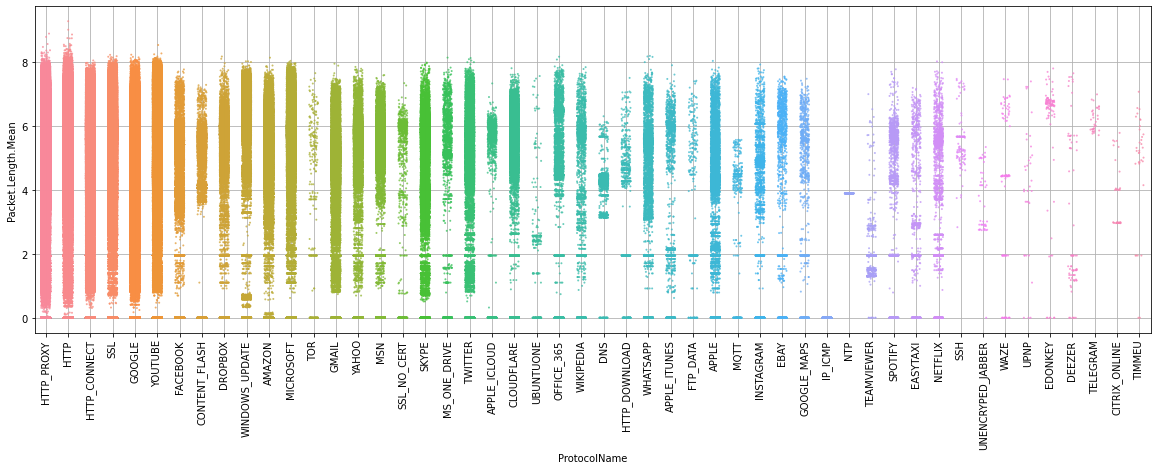

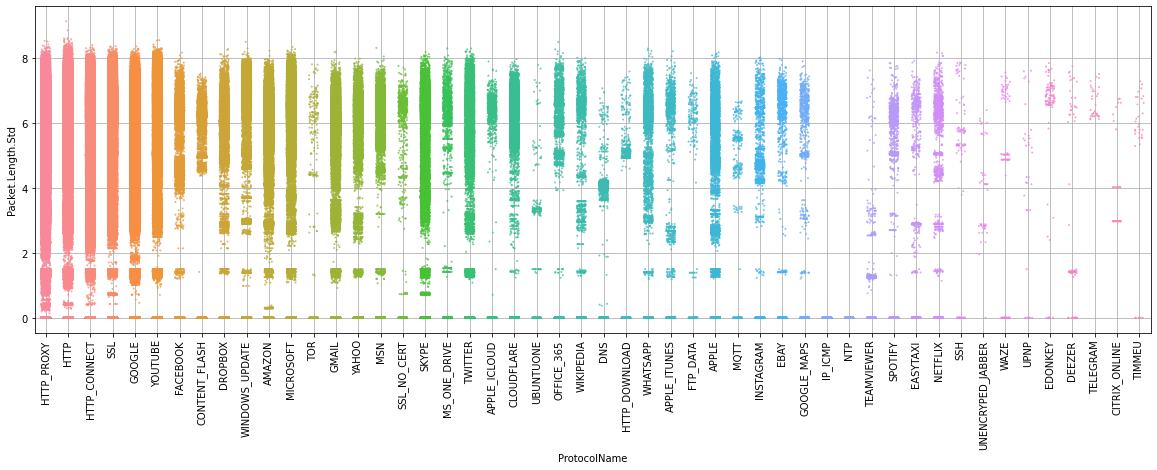

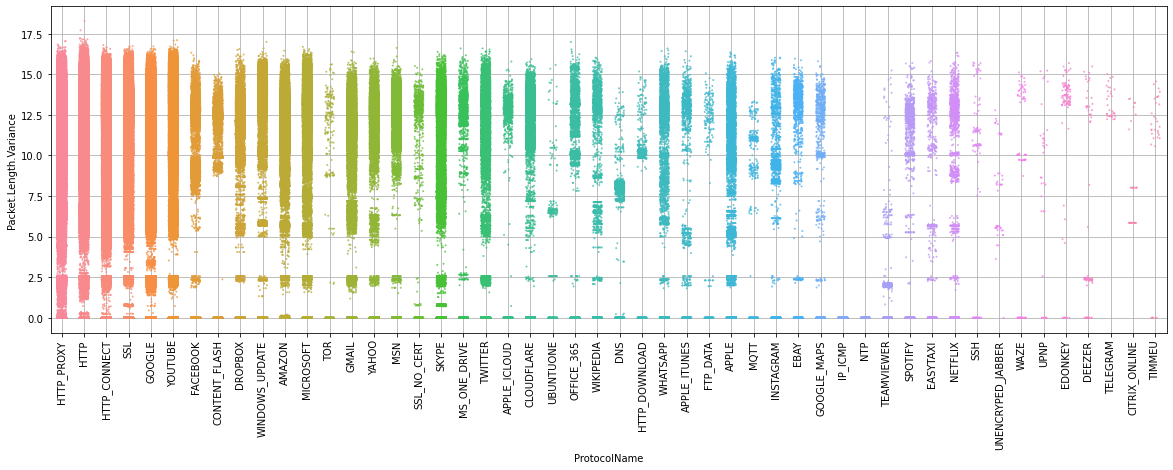

In [12]:
for col in df.columns:
    if col.startswith("Packet"):
        feature_per_target(col)

<AxesSubplot:>

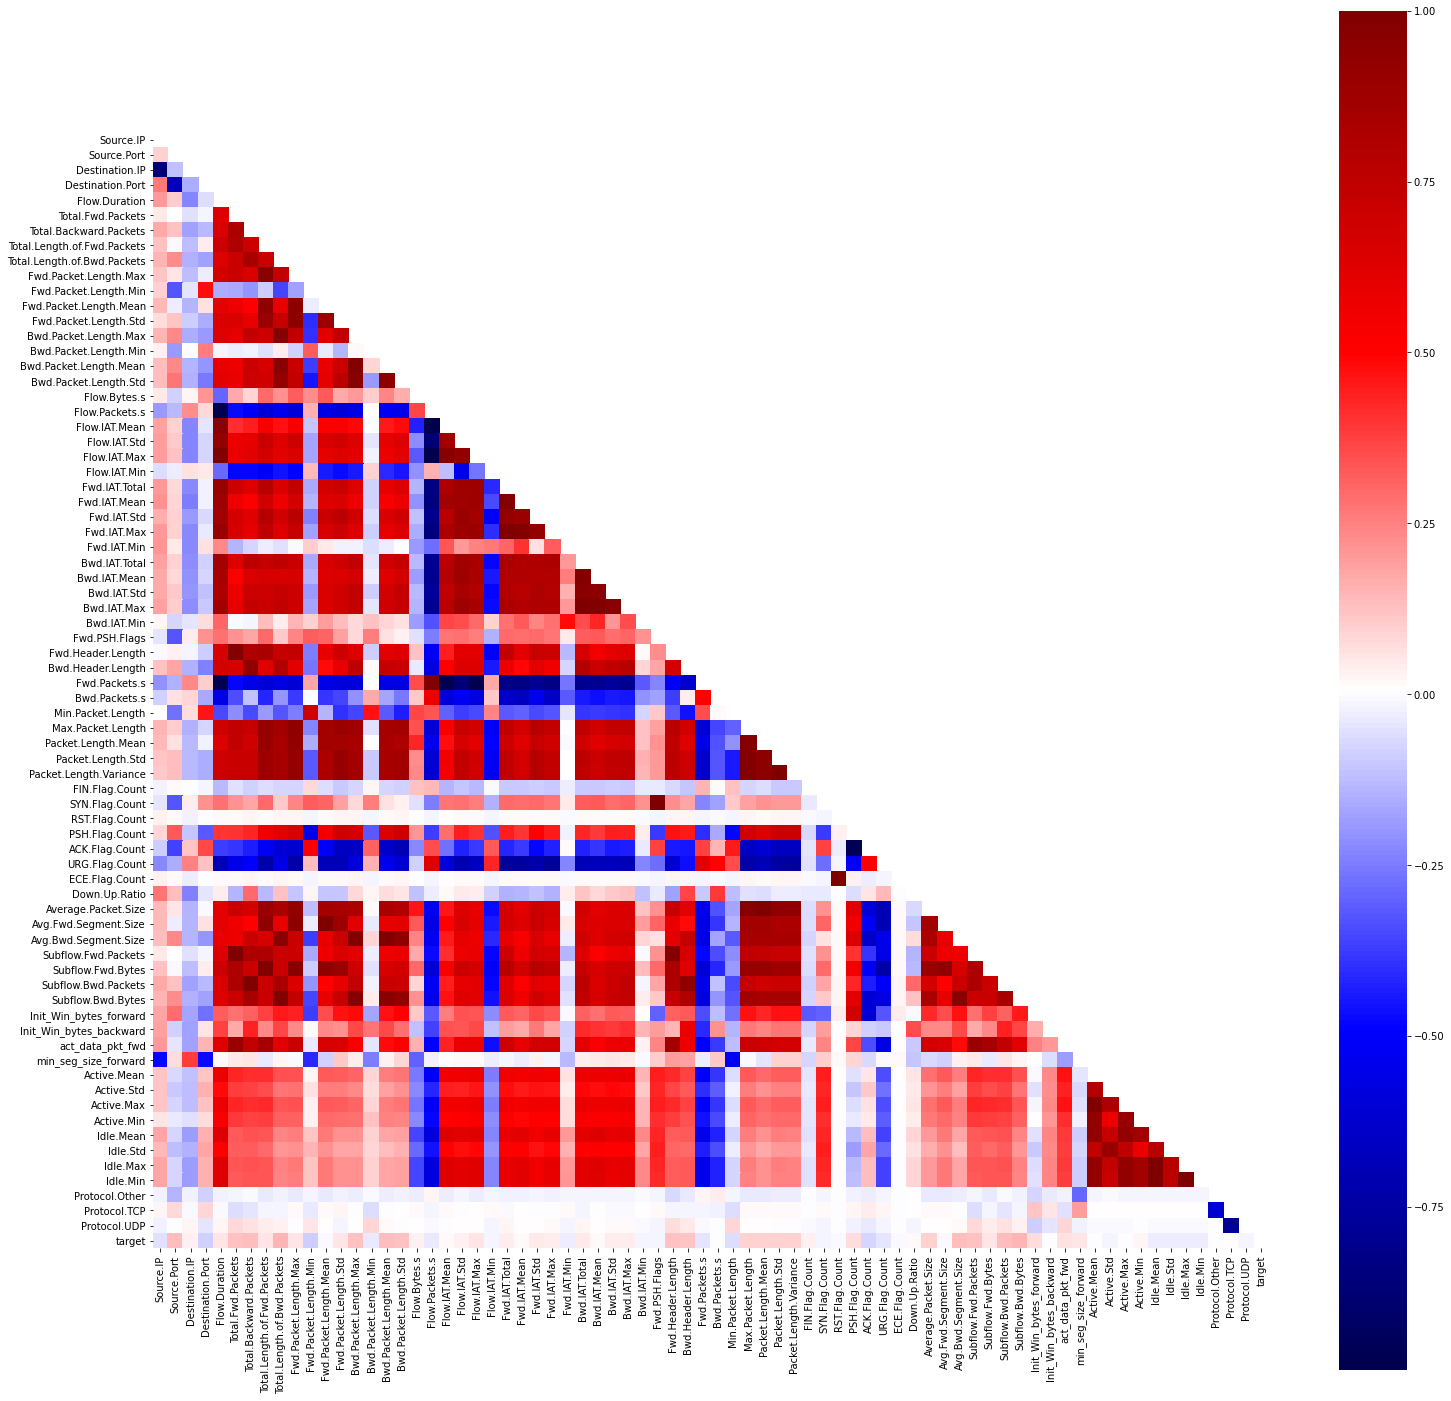

In [13]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25, 25))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic")

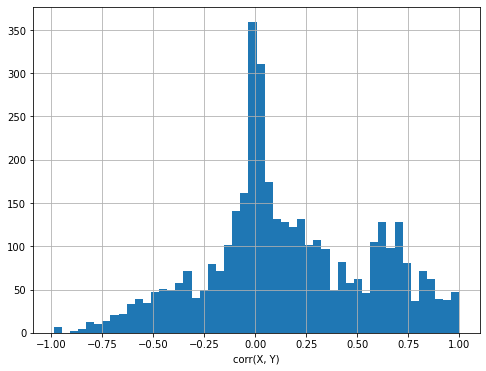

In [72]:
corr_list = (corr.mask(mask)
             .unstack()
             .dropna()
             .reset_index()
             .rename(columns={"level_0": "X", "level_1": "Y", 0: "corr(X, Y)"})
             .query("X!=Y")
             .sort_values(by="corr(X, Y)", ascending=False))

plt.figure(figsize=(8, 6))
plt.xlabel("corr(X, Y)")
corr_list["corr(X, Y)"].hist(bins=50);

## Constructing new features

In [2]:
df = pd.read_parquet("preprocessed_all.parquet")

In [3]:
df

Source.IP  Source.Port  Destination.IP  Destination.Port  \
0        2886926638        52422       180881159              3128   
1         180881159         3128      2886926638             52422   
2         840939815           80       180881369             38848   
3         840939815           80       180881369             38848   
4        3232253995        55961       180881159              3128   
...             ...          ...             ...               ...   
3567188  1653231433          443       180881351             42135   
3567189  1653231433          443       180881369             51546   
3567190  1653231433          443       180881370             44366   
3567191  1653231433          443       180881347             52341   
3567192  1653231433          443       180881348             34188   

         Flow.Duration  Total.Fwd.Packets  Total.Backward.Packets  \
0                45523                 22                      55   
1                    1                  2                       0   
2                    1                  3                       0   
3                  217                  1                       3   
4                78068                  5                       0   
...                ...                ...                     ...   
3567188        2290821                  5                       4   
3567189             24                  5                       0   
3567190        2591653                  6                       5   
3567191        2622421                  4                       3   
3567192        2009138                  3                       2   

         Total.Length.of.Fwd.Packets  Total.Length.of.Bwd.Packets  \
0                                132                       110414   
1                                 12                            0   
2                                674                            0   
3                                  0                            0   
4                               1076                            0   
...                              ...                          ...   
3567188                          599                         2159   
3567189                         1448                            0   
3567190                         1202                         4184   
3567191                          632                         2352   
3567192                          597                         2076   

         Fwd.Packet.Length.Max  ...  Active.Min  Idle.Mean  Idle.Std  \
0                            6  ...         0.0        0.0       0.0   
1                            6  ...         0.0        0.0       0.0   
2                          337  ...         0.0        0.0       0.0   
3                            0  ...         0.0        0.0       0.0   
4                          529  ...         0.0        0.0       0.0   
...                        ...  ...         ...        ...       ...   
3567188                    599  ...         0.0        0.0       0.0   
3567189                   1448  ...         0.0        0.0       0.0   
3567190                    601  ...         0.0        0.0       0.0   
3567191                    352  ...         0.0        0.0       0.0   
3567192                    597  ...         0.0        0.0       0.0   

         Idle.Max  Idle.Min  ProtocolName  Protocol.Other  Protocol.TCP  \
0             0.0       0.0    HTTP_PROXY               0             1   
1             0.0       0.0    HTTP_PROXY               0             1   
2             0.0       0.0          HTTP               0             1   
3             0.0       0.0          HTTP               0             1   
4             0.0       0.0    HTTP_PROXY               0             1   
...           ...       ...           ...             ...           ...   
3567188       0.0       0.0           SSL               0             1   
3567189       0.0       0.0           SSL     

<AxesSubplot:>

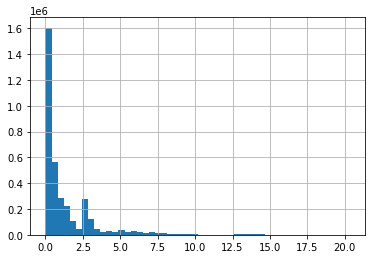

In [17]:
np.log((df["Total.Length.of.Fwd.Packets"]/(df["Total.Length.of.Bwd.Packets"]+1))+1).hist(bins=50)

<AxesSubplot:>

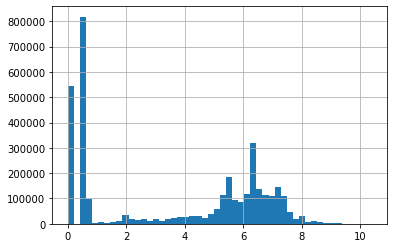

In [18]:
np.log((df["Fwd.Packet.Length.Max"]/(df["Fwd.Packet.Length.Min"]+1))+1).hist(bins=50)

<AxesSubplot:>

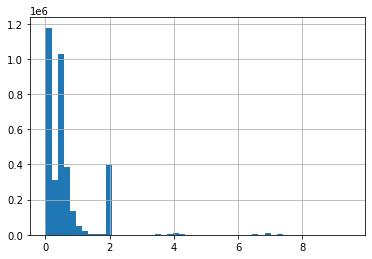

In [19]:
np.log((df["Bwd.Packet.Length.Mean"]/(df["Bwd.Packet.Length.Std"]+1))+1).hist(bins=50)

<AxesSubplot:>

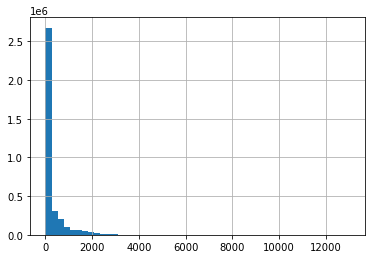

In [20]:
df["Bwd.Packet.Length.Mean"].hist(bins=50)

<AxesSubplot:>

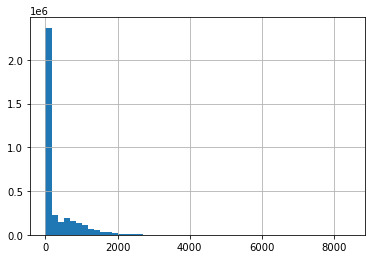

In [21]:
df["Bwd.Packet.Length.Std"].hist(bins=50)

In [22]:
(df["Bwd.Packet.Length.Mean"]/(df["Bwd.Packet.Length.Std"]+1))

0          2.608934
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
3567188    0.842037
3567189    0.000000
3567190    0.908426
3567191    0.576925
3567192    0.706625
Length: 3567193, dtype: float64

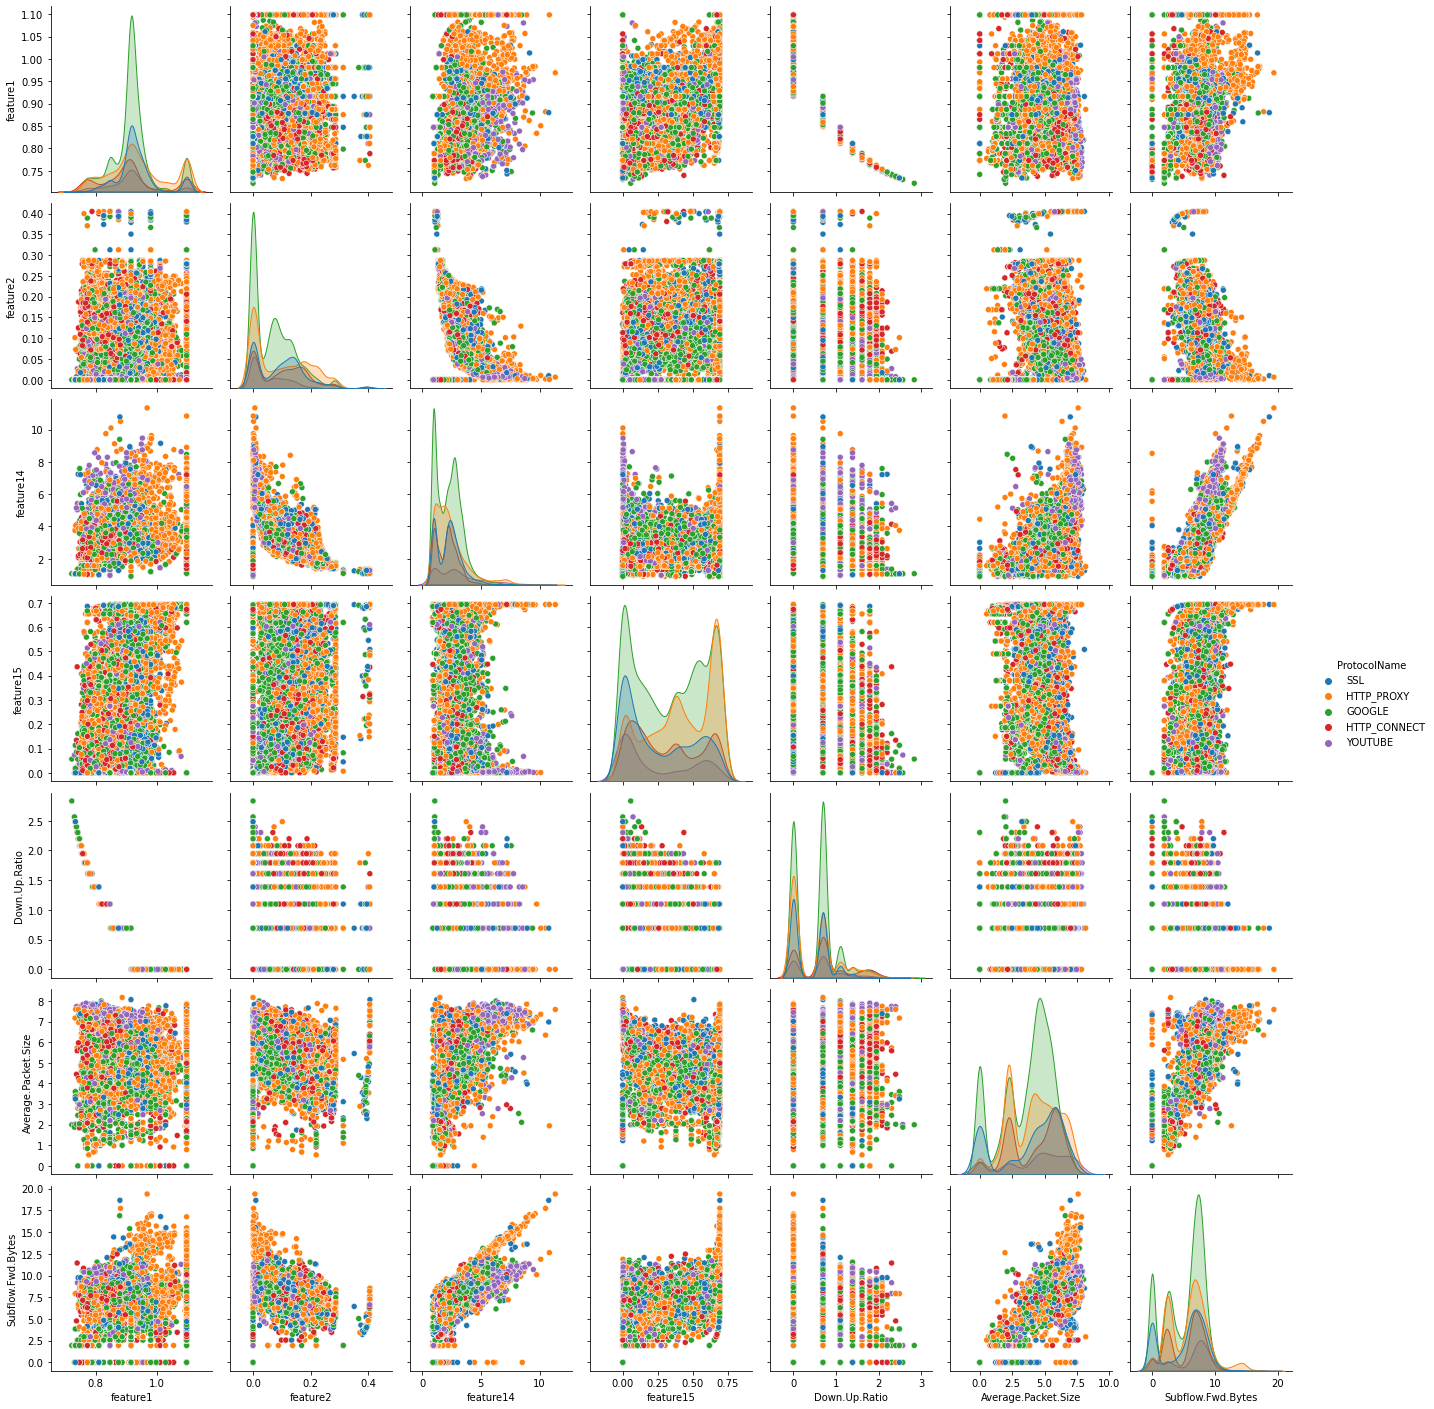

In [23]:
tmp = df[df["ProtocolName"].isin({"GOOGLE", "YOUTUBE", "SSL", "HTTP_PROXY", "HTTP_CONNECT"})].copy()

tmp["feature1"] = (tmp["Total.Fwd.Packets"]/(tmp["Total.Backward.Packets"]+tmp["Total.Fwd.Packets"])+1)
tmp["feature2"] = (tmp["Fwd.Packet.Length.Std"]/(tmp["Fwd.Packet.Length.Max"] - tmp["Fwd.Packet.Length.Min"]+1))**2
tmp["feature3"] = tmp["Total.Length.of.Fwd.Packets"]/(tmp["Total.Length.of.Bwd.Packets"]+1)
tmp["feature4"] = tmp["Fwd.Packet.Length.Max"]/(tmp["Fwd.Packet.Length.Min"]+1)
tmp["feature5"] = tmp["Bwd.Packet.Length.Max"]/(tmp["Bwd.Packet.Length.Min"]+1)
tmp["feature6"] = tmp["Fwd.Packet.Length.Mean"]/(tmp["Fwd.Packet.Length.Std"]+1)
tmp["feature7"] = tmp["Bwd.Packet.Length.Mean"]/(tmp["Bwd.Packet.Length.Std"]+1)
tmp["feature8"] = tmp["Fwd.IAT.Total"]/(tmp["Bwd.IAT.Total"]+1)
tmp["feature9"] = ((tmp["Fwd.IAT.Std"]/(tmp["Fwd.IAT.Max"] - tmp["Fwd.IAT.Min"] + 1))**2)
tmp["feature10"] = ((tmp["Bwd.IAT.Std"]/(tmp["Bwd.IAT.Max"] - tmp["Bwd.IAT.Min"] + 1))**2)
tmp["feature11"] = (tmp['Flow.Bytes.s']/(tmp['Flow.Packets.s']+1))*((tmp['Flow.Bytes.s']/(tmp['Flow.Packets.s']+1)) - 2)
tmp["feature12"] = (tmp[[col for col in df.columns if col.endswith(".Flag.Count")]]*[10**i for i in range(7)]).sum(axis=1)
tmp["feature13"] = np.exp(np.sqrt((tmp[[col for col in tmp.columns if col.endswith("Flag.Count")]]).sum(axis=1)))
tmp["feature14"] = (tmp["Subflow.Fwd.Packets"]+tmp["Subflow.Bwd.Packets"]/(tmp["Total.Fwd.Packets"]+tmp["Total.Backward.Packets"]))
tmp["feature15"] = (tmp["Subflow.Fwd.Bytes"]/(tmp["Subflow.Fwd.Bytes"]+tmp["Subflow.Bwd.Bytes"]+1))

for col in tmp.columns:
    if col in ["ProtocolName", "target"]:
        continue
    else:
        tmp[col] = np.log(tmp[col].abs()+1)
        
g = sns.pairplot(tmp[['feature1','feature2','feature14',  'feature15', 'ProtocolName', 'Down.Up.Ratio', 'Average.Packet.Size', "Subflow.Fwd.Bytes"]].sample(20000), hue="ProtocolName")
g.fig.set_size_inches(20, 20)

In [24]:
iat_cols = [col for col in df.columns if "IAT" in col]
df.sample(20000)[iat_cols].describe().round(1)

Flow.IAT.Mean  Flow.IAT.Std  Flow.IAT.Max  Flow.IAT.Min  Fwd.IAT.Total  \
count        20000.0       20000.0       20000.0       20000.0        20000.0   
mean       1426351.4     3373685.2    12880301.5       85734.2     24567618.0   
std        3493777.6     6211260.7    20687881.5     1507198.7     39910865.8   
min              0.2           0.0           1.0           0.0            0.0   
25%            428.3          16.7         591.8           0.0           12.0   
50%          34410.8       70481.2      283576.5           1.0       402423.0   
75%         936254.7     4110335.1    25051695.5          31.0     43694200.0   
max      108390322.0    84824949.5   119960594.0   108390322.0    119999993.0   

       Fwd.IAT.Mean  Fwd.IAT.Std  Fwd.IAT.Max  Fwd.IAT.Min  Bwd.IAT.Total  \
count       20000.0      20000.0      20000.0      20000.0        20000.0   
mean      3108928.4    3728811.1   12195253.0    1200955.5     21320995.9   
std       8152977.7    7463161.7   20519469.6    6946991.2     38801316.6   
min             0.0          0.0          0.0          0.0            0.0   
25%             8.0          0.0         12.0          0.0            0.0   
50%         38078.5      51199.2     219959.0          0.0       185251.5   
75%       1569097.8    3160656.4   19924117.5         89.0     15406665.0   
max     108390322.0   84824949.5  119960594.0  108390322.0    119999994.0   

       Bwd.IAT.Mean  Bwd.IAT.Std  Bwd.IAT.Max  Bwd.IAT.Min  
count       20000.0      20000.0      20000.0      20000.0  
mean      2470746.2    2935867.0    9797625.4     866810.5  
std       7531932.2    6533652.4   18581358.0    6180951.9  
min             0.0          0.0          0.0          0.0  
25%             0.0          0.0          0.0          0.0  
50%         16088.1      27127.5      96483.5          0.0  
75%        346401.2     810084.4    7845575.8          1.0  
max     119256032.0   68714886.1  119837751.0  119256032.0

<AxesSubplot:>

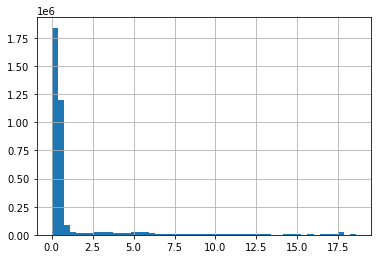

In [25]:
np.log((df["Fwd.IAT.Mean"]/((df["Fwd.IAT.Std"]) + 1))+1).hist(bins=50)

count    3.567193e+06
mean     1.096358e-01
std      1.355283e-01
min      0.000000e+00
25%      0.000000e+00
50%      6.631645e-02
75%      1.654564e-01
max      5.000000e-01
dtype: float64

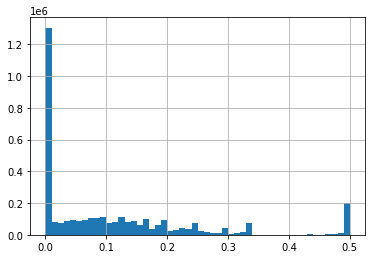

In [26]:
feature = ((df["Fwd.IAT.Std"]/(df["Fwd.IAT.Max"] - df["Fwd.IAT.Min"] + 1))**2)
feature.hist(bins=50)
feature.describe()

count    3.567193e+06
mean     9.795320e-02
std      1.286218e-01
min      0.000000e+00
25%      0.000000e+00
50%      4.165803e-02
75%      1.618057e-01
max      5.000000e-01
dtype: float64

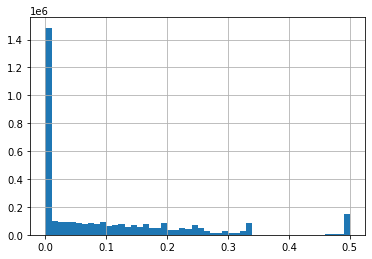

In [27]:
feature = ((df["Bwd.IAT.Std"]/(df["Bwd.IAT.Max"] - df["Bwd.IAT.Min"] + 1))**2)
feature.hist(bins=50)
feature.describe()

count    3.567193e+06
mean     3.478536e+06
std      7.155060e+07
min      0.000000e+00
25%      1.871595e+01
50%      1.123968e+03
75%      2.306795e+04
max      1.439600e+10
Name: Flow.Bytes.s, dtype: float64

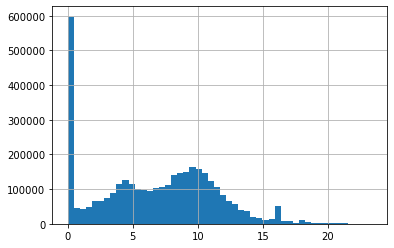

In [28]:
np.log(df['Flow.Bytes.s'].abs()+1).hist(bins=50)
df['Flow.Bytes.s'].describe()

count    3.567193e+06
mean     8.416300e+04
std      3.919009e+05
min      1.666667e-02
25%      1.118218e+00
50%      3.346112e+01
75%      4.073320e+03
max      6.000000e+06
Name: Flow.Packets.s, dtype: float64

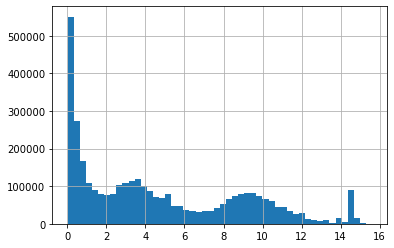

In [29]:
np.log(df['Flow.Packets.s'].abs()+1).hist(bins=50)
df['Flow.Packets.s'].describe()

<AxesSubplot:>

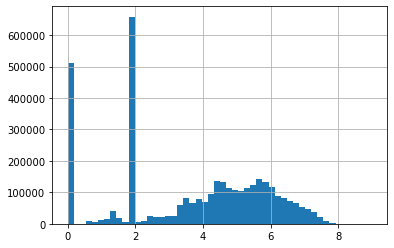

In [30]:
np.log((df['Flow.Bytes.s']/df['Flow.Packets.s'])+1).hist(bins=50)

<AxesSubplot:>

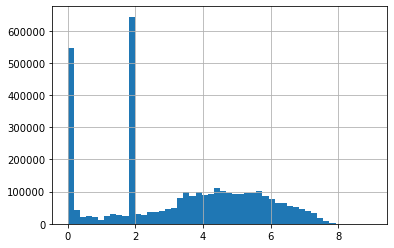

In [31]:
feat = (df['Flow.Bytes.s']/(df['Flow.Packets.s']+1))
np.log(feat.abs()+1).hist(bins=50)

count    3.567193e+06
mean     1.577714e+00
std      1.326265e+00
min      0.000000e+00
25%      1.003216e-01
50%      1.792160e+00
75%      2.831896e+00
max      4.156681e+00
dtype: float64

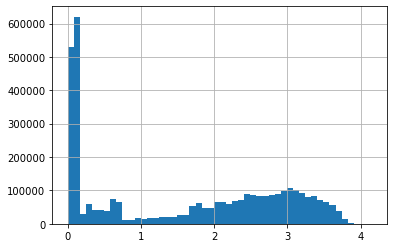

In [32]:
feat = (df['Flow.Bytes.s']/(df['Flow.Packets.s']+1))
feat = np.log(feat.abs()+1)
feat = np.log(feat*(feat-2).abs()+1)
feat.hist(bins=50)
feat.describe()

In [33]:
df[[col for col in df.columns if col.endswith(".Flag.Count")]]*[10**i for i in range(7)]

FIN.Flag.Count  SYN.Flag.Count  RST.Flag.Count  PSH.Flag.Count  \
0                     0               0               0               0   
1                     0               0               0               0   
2                     0              10               0               0   
3                     0               0               0               0   
4                     0              10               0               0   
...                 ...             ...             ...             ...   
3567188               0              10               0               0   
3567189               0               0               0               0   
3567190               0              10               0               0   
3567191               0              10               0               0   
3567192               0              10               0               0   

         ACK.Flag.Count  URG.Flag.Count  ECE.Flag.Count  
0                 10000               0               0  
1                 10000          100000               0  
2                 10000               0               0  
3                 10000          100000               0  
4                 10000               0               0  
...                 ...             ...             ...  
3567188           10000               0               0  
3567189           10000               0               0  
3567190           10000               0               0  
3567191           10000               0               0  
3567192           10000               0               0  

[3567193 rows x 7 columns]

In [34]:
df[[col for col in df.columns if col.startswith("Subflow")]].describe()

Subflow.Fwd.Packets  Subflow.Fwd.Bytes  Subflow.Bwd.Packets  \
count         3.567193e+06       3.567193e+06         3.567193e+06   
mean          6.251488e+01       4.695217e+04         6.550379e+01   
std           1.095397e+03       1.818743e+06         1.109565e+03   
min           1.000000e+00       0.000000e+00         0.000000e+00   
25%           2.000000e+00       1.200000e+01         1.000000e+00   
50%           6.000000e+00       4.450000e+02         5.000000e+00   
75%           1.500000e+01       1.777000e+03         1.500000e+01   
max           4.531900e+05       6.780236e+08         5.421960e+05   

       Subflow.Bwd.Bytes  
count       3.567193e+06  
mean        8.468690e+04  
std         2.127309e+06  
min         0.000000e+00  
25%         0.000000e+00  
50%         2.160000e+02  
75%         3.638000e+03  
max         1.345796e+09

count    3.055026e+06
mean     1.812629e+00
std      6.252351e-01
min      1.000000e+00
25%      1.222348e+00
50%      1.648721e+00
75%      2.479560e+00
max      2.718282e+00
dtype: float64

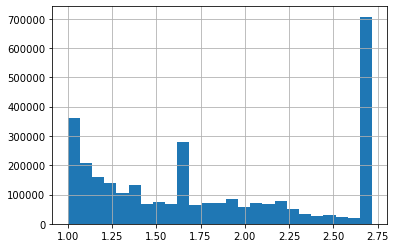

In [35]:
np.exp((df["Subflow.Fwd.Bytes"]/(df["Subflow.Fwd.Bytes"]+df["Subflow.Bwd.Bytes"]))).hist(bins=25)
np.exp((df["Subflow.Fwd.Bytes"]/(df["Subflow.Fwd.Bytes"]+df["Subflow.Bwd.Bytes"]))).describe()

count    3.567193e+06
mean     6.251488e+01
std      1.095397e+03
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      4.531900e+05
Name: Total.Fwd.Packets, dtype: float64

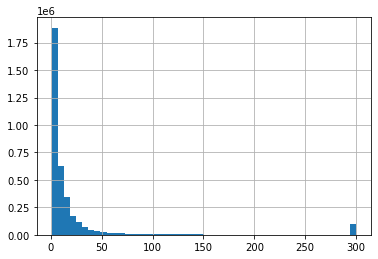

In [36]:
df["Total.Fwd.Packets"].clip(0, 300).hist(bins=50)
df["Total.Fwd.Packets"].describe()

count    3.567193e+06
mean     6.550379e+01
std      1.109565e+03
min      0.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      1.500000e+01
max      5.421960e+05
Name: Total.Backward.Packets, dtype: float64

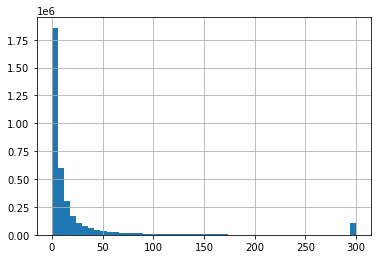

In [37]:
df["Total.Backward.Packets"].clip(0, 300).hist(bins=50)
df["Total.Backward.Packets"].describe()

<AxesSubplot:>

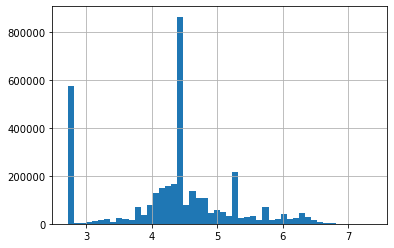

In [38]:
np.exp(((df["Total.Backward.Packets"]/(df["Total.Backward.Packets"]+df["Total.Fwd.Packets"]))+1)).hist(bins=50)

In [39]:
np.exp((df["Total.Backward.Packets"]/(df["Total.Backward.Packets"]+df["Total.Fwd.Packets"])+1))

0          5.552708
1          2.718282
2          2.718282
3          5.754603
4          2.718282
             ...   
3567188    4.239496
3567189    2.718282
3567190    4.282536
3567191    4.172734
3567192    4.055200
Length: 3567193, dtype: float64

## Check correlations with new features

In [40]:
def add_features(df):
    df["feature1"] = (df["Total.Fwd.Packets"]/(df["Total.Backward.Packets"]+df["Total.Fwd.Packets"])+1)
    df["feature2"] = (df["Fwd.Packet.Length.Std"]/(df["Fwd.Packet.Length.Max"] - df["Fwd.Packet.Length.Min"]+1))**2
    df["feature3"] = df["Total.Length.of.Fwd.Packets"]/(df["Total.Length.of.Bwd.Packets"]+1)
    df["feature4"] = df["Fwd.Packet.Length.Max"]/(df["Fwd.Packet.Length.Min"]+1)
    df["feature5"] = df["Bwd.Packet.Length.Max"]/(df["Bwd.Packet.Length.Min"]+1)
    df["feature6"] = df["Fwd.Packet.Length.Mean"]/(df["Fwd.Packet.Length.Std"]+1)
    df["feature7"] = df["Bwd.Packet.Length.Mean"]/(df["Bwd.Packet.Length.Std"]+1)
    df["feature8"] = df["Fwd.IAT.Total"]/(df["Bwd.IAT.Total"]+1)
    df["feature9"] = ((df["Fwd.IAT.Std"]/(df["Fwd.IAT.Max"] - df["Fwd.IAT.Min"] + 1))**2)
    df["feature10"] = ((df["Bwd.IAT.Std"]/(df["Bwd.IAT.Max"] - df["Bwd.IAT.Min"] + 1))**2)
    df["feature11"] = (df['Flow.Bytes.s']/(df['Flow.Packets.s']+1))*((df['Flow.Bytes.s']/(df['Flow.Packets.s']+1)) - 2)
    df["feature12"] = (df[[col for col in df.columns if col.endswith(".Flag.Count")]]*[10**i for i in range(7)]).sum(axis=1)
    df["feature13"] = np.exp(np.sqrt((df[[col for col in df.columns if col.endswith("Flag.Count")]]).sum(axis=1)))
    df["feature14"] = (df["Subflow.Fwd.Packets"]+df["Subflow.Bwd.Packets"]/(df["Total.Fwd.Packets"]+df["Total.Backward.Packets"]))
    df["feature15"] = (df["Subflow.Fwd.Bytes"]/(df["Subflow.Fwd.Bytes"]+df["Subflow.Bwd.Bytes"]+1))
    df = df[[col for col in df.columns if col not in {"ProtocolName", "target"}]+["ProtocolName", "target"]]
    return df

In [41]:
df = pd.read_parquet("preprocessed_all.parquet")

In [42]:
df = add_features(df)

In [43]:
for col in df.columns:
    if col in ["ProtocolName", "target"]:
        continue
    else:
        df[col] = np.log(df[col].abs()+1)

<AxesSubplot:>

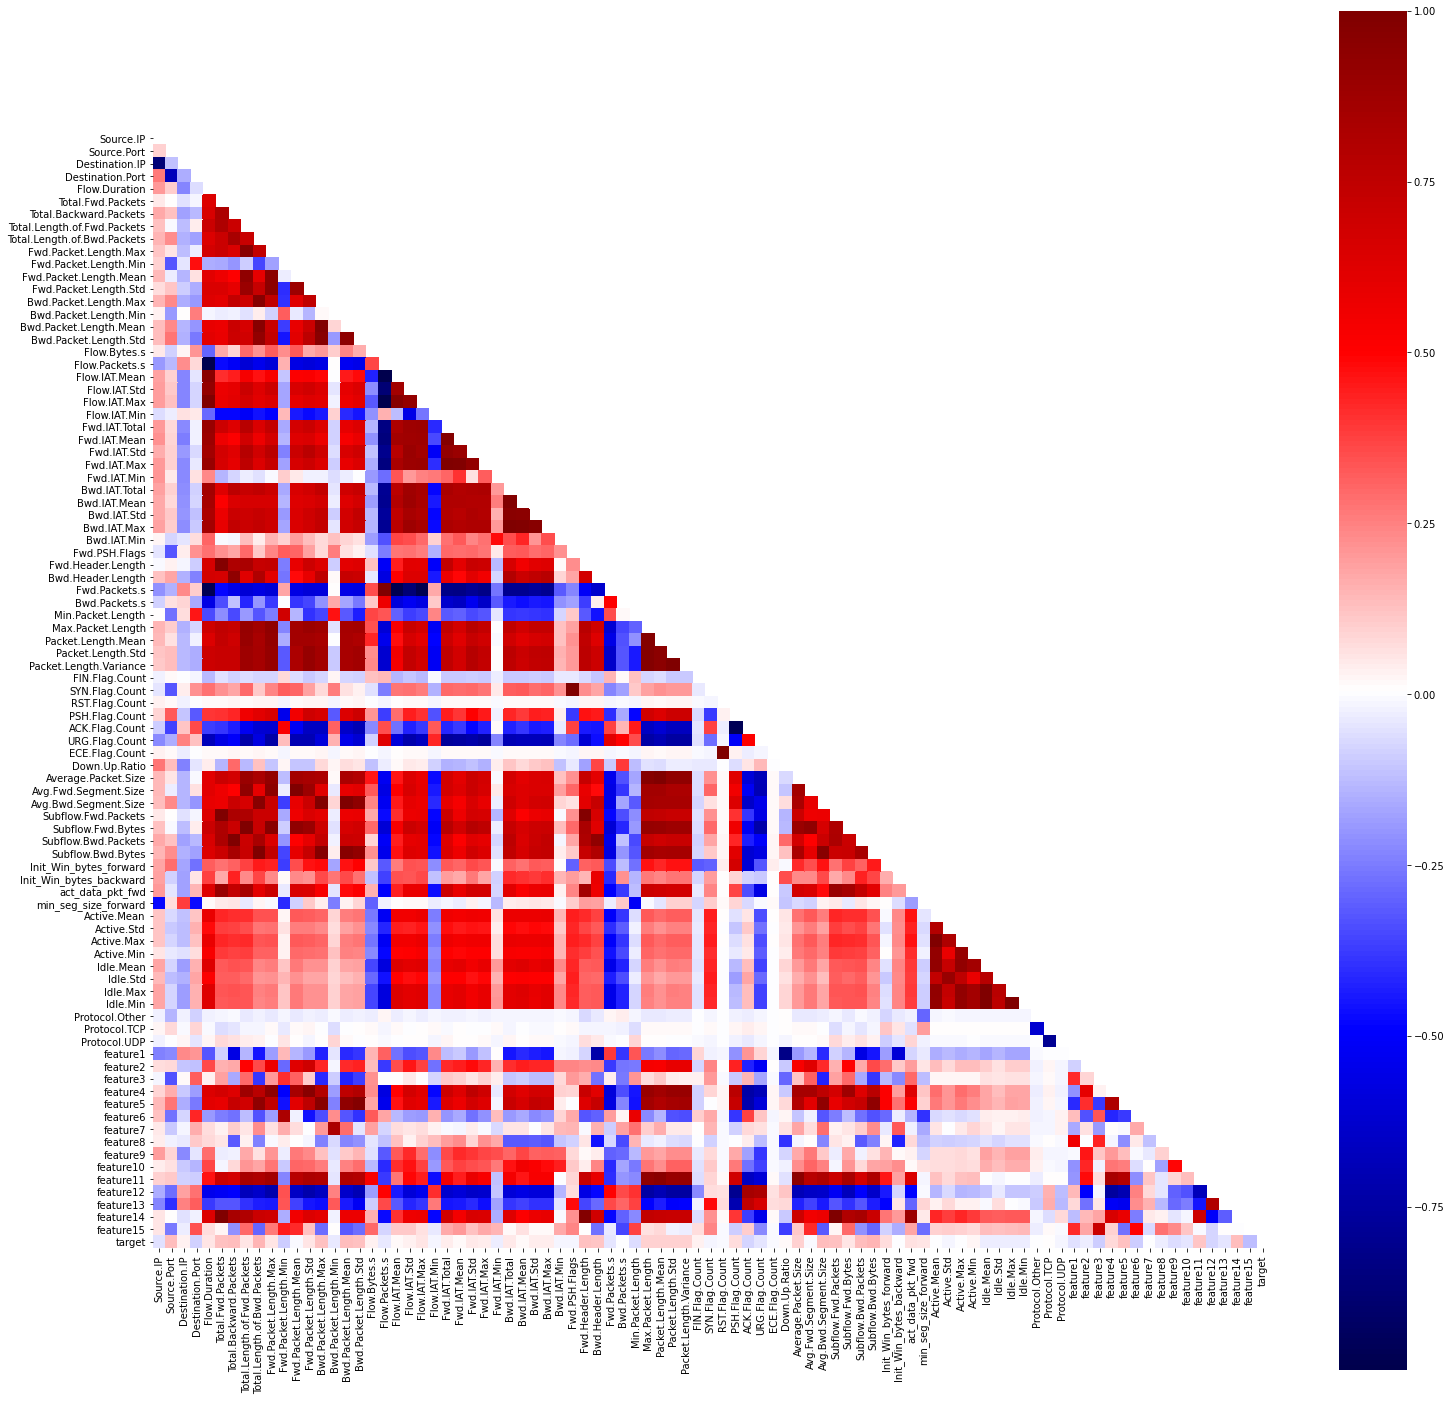

In [44]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25, 25))
sns.heatmap(corr, square=True, mask=mask, cmap="seismic")

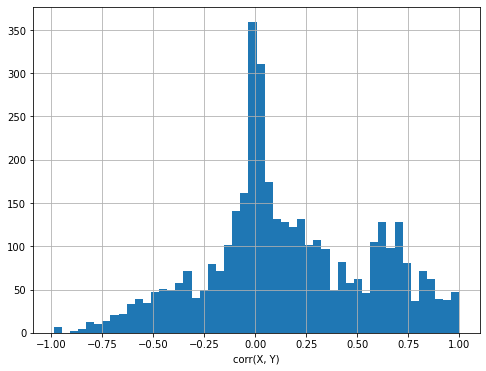

In [70]:
corr_list = (corr.mask(mask)
             .unstack()
             .dropna()
             .reset_index()
             .rename(columns={"level_0": "X", "level_1": "Y", 0: "corr(X, Y)"})
             .query("X!=Y")
             .sort_values(by="corr(X, Y)", ascending=False))

plt.figure(figsize=(8, 6))
plt.xlabel("corr(X, Y)")
corr_list["corr(X, Y)"].hist(bins=50);